In [1]:
# warmup
num_list = [1,2,3,4,5,6,7,8,9,10]
odd_list = list(filter(lambda x : x % 2!= 0,num_list))
odd_list

[1, 3, 5, 7, 9]

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn import tree

In [2]:
pima_df = pd.read_csv('../SupervisedML_13/diabetes.csv')
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# I am checking for outliers. Maximum values for all features are reasonable. No values look strange for me. 
# there is no outliers in our dataset.

pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 1.Work to improve the model performance for the diabetes decision tree we created in class. You should be able to improve the precision and recall to be above .8 and .7 respectively. You can improve the preprocessing OR alter the model itself.

In [5]:
# model which we did in class
X = pima_df.drop('Outcome',axis = 1)
y = pima_df['Outcome']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=6, stratify=y)

#Standardize
sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_test_scale = sc.fit_transform(X_test)

# fitting the model
decision_tree = tree.DecisionTreeClassifier(max_depth = 8, random_state = 6)
decision_tree.fit(X_train_scale,y_train)
y_pred = decision_tree.predict(X_test_scale)

# printing performance metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       150
           1       0.59      0.57      0.58        81

    accuracy                           0.71       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.71      0.71      0.71       231



In [6]:
y_train.value_counts()

0    350
1    187
Name: Outcome, dtype: int64

#### Using resamplimg to improve precision, recall

* There is an imbalance in Outcome column. I am using SMOTE resampling technique to balance the data. 

In [47]:
# I am going to re-balance the data using SMOTE
smote = SMOTE(random_state =6 )
X_resample, y_resample = smote.fit_resample(X_train_scale,y_train)

# fitting the model for resampled inputs
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(X_resample,y_resample)
y_pred = decision_tree.predict(X_test_scale)

# Since I did resampling, I am checking classification_report_imbalanced metric from sklearn.imblearn library
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.67      0.84      0.77      0.75      0.56       150
          1       0.58      0.84      0.67      0.69      0.75      0.57        81

avg / total       0.78      0.73      0.78      0.74      0.75      0.56       231



* My recall was improved well after balancing data. But still no improvements from precision. 

#### Hyper parameter tuning with GridSearchCV

* I decided to tune decision tree hyper parameters with cross validation. And also I have treated 0s in our dataset as Nans and replaced it with its mean. 

In [13]:
pima_df['SkinThickness']=pima_df['SkinThickness'].replace(0,pima_df['SkinThickness'].mean())

In [14]:
pima_df['Insulin'] = pima_df['Insulin'].replace(0,pima_df['Insulin'].mean())

In [15]:
pima_df['BMI'] = pima_df['BMI'].replace(0,pima_df['BMI'].mean())

In [16]:
pima_df['Glucose'] = pima_df['Glucose'].replace(0,pima_df['Glucose'].mean())

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.71      0.85      0.79      0.78      0.59       150
          1       0.61      0.85      0.71      0.71      0.78      0.61        81

avg / total       0.80      0.76      0.80      0.76      0.78      0.60       231



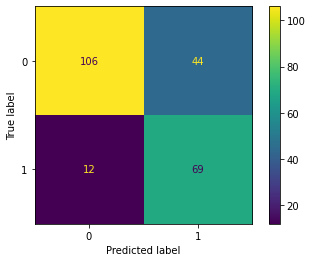

In [51]:
# fitting the model
decision_tree = tree.DecisionTreeClassifier(random_state = 6)
parameters = {'criterion':['gini'], 
              'max_depth':[4],
              'max_features':[8],
              'min_samples_split': np.arange(5,20),
              'min_samples_leaf':np.arange(5,20)}

grid = GridSearchCV(decision_tree,parameters, cv = 10)
grid.fit(X_resample,y_resample)

# predicting outcome
y_pred = grid.predict(X_test_scale)
y_pred_prob = grid.predict_proba(X_test_scale)[:,1]

# printing performance metrics
print(classification_report_imbalanced(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot();

#### Great Improvement in recall compare to other classifiers as far we used

Comparing performance 

|       metrics          |    KNN Method | LogisticRegression | Logistic Regression after SMOTE| Decision Tree Classifier|
|:----------------------:|:-------------:|:------------------:|:------------------------------:|:-----------------------:|
| RECALL score           |       0.59    |        0.52        |          0.67                  |          0.85           |
| No. of False Negatives |        33     |         43         |           27                   |           12            |

#### Increasing Decision Threshold

* We can find the best value for Decision Threshold which will give High Precision(Without affection Recall much) or High Recall(Without affecting Precision much). Calculated Optimal threshold from roc curve and used it as Decision threshold.

In [52]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
optimal = np.argmax(tpr - fpr) 
optimal_threshold = thresholds[optimal]
print(optimal_threshold)

0.6265060240963856


                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.84      0.77      0.85      0.80      0.65       150
          1       0.72      0.77      0.84      0.74      0.80      0.64        81

avg / total       0.82      0.81      0.79      0.82      0.80      0.64       231



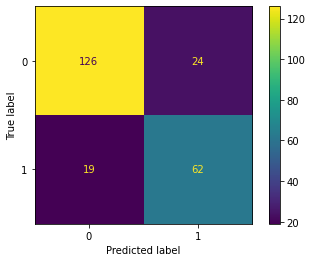

In [53]:
prediction = []
decision_threshold = 0.62
for i in y_pred_prob:
    if i < decision_threshold:
        prediction.append(0)
    else:
        prediction.append(1)
        
print(classification_report_imbalanced(y_test,prediction))
cm = confusion_matrix(y_test,prediction)
ConfusionMatrixDisplay(cm).plot();

* Model performed well and gave an improvement in precision score. But our recall value reduced slightly. But I can proudly say that this model predicted 0s as 0 and 1s as 1 well. Because we got both precision and recall score for class 1 above 70%.

#### Is Overfitted or Underfitted?

* We can find whether our model is overfitted or underfitted by using training score and testing score.
* Both scores are equal. So its not under or over fitted model.

In [57]:
print("Training Score",grid.score(X_train_scale,y_train).round(2))
print("Testing Score",grid.score(X_test_scale,y_test).round(2))

Training Score 0.76
Testing Score 0.76


#### decision tree diagram

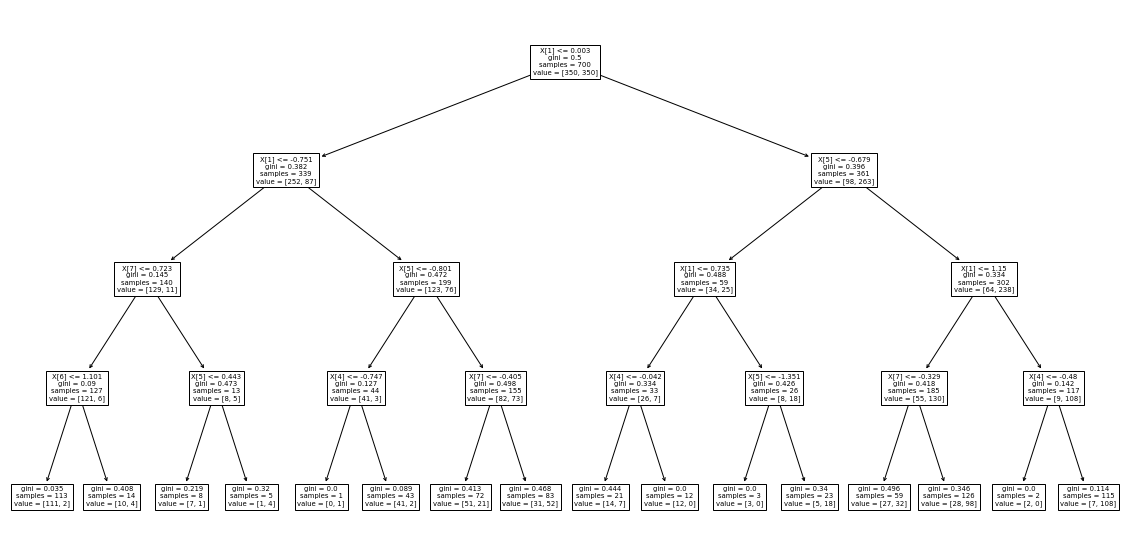

In [50]:
fig,ax = plt.subplots(figsize = (20,10))
tree.plot_tree(decision_tree)
plt.savefig("tree.svg")
plt.show()

### Steps I have used to increase precison and recall:

* Treated 0s in the dataset as Nans and replaced 0s with mean(preprocessing)

* Standardized the data(preprocessing)

* I did rebalance the data using SMOTE Technique(resampling)

* Used GridSearchCV method and tuned my parameters(Hyper Parameter tuning)

* Changed the threshold value to increase precision score.

## 2. Create a function that accepts an array of names and returns a string formatted as a list of names separated by commas EXCEPT for the last two names, which are separated by an ampersand (and sign - &)
Example input:
[ {'name': 'Nichole'}, {'name': 'Tanisha'}, {'name': 'Maggie'} ]

Example output:
Nichole, Tanisha & Maggie

In [68]:
def name_comma(namelist):
    name_str = ""
    if len(namelist) != 0:
        name_arr = []
        for i in range(0, len(namelist) - 1):
            name_arr.append(namelist[i]['name'])
            name_str = ', '.join(name_arr)
            name_str += ' & ' + namelist[-1]['name'] if name_str != '' else namelist[-1]['name']
    print(name_str)

In [69]:
name_list = [ {'name': 'Nichole'}, {'name': 'Tanisha'}, {'name': 'Maggie'}, {'name': 'Mangai'}]
name_comma(name_list)

Nichole, Tanisha, Maggie & Mangai
